In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as r

%matplotlib inline

import os
import requests
import json
import math
import re

from datetime import date, time, datetime

import googleapiclient.discovery
import googleapiclient.errors

In [2]:
%run setAPIkey.py

In [3]:
API_KEY = os.getenv('YT_API')

In [4]:
api_service_name = 'youtube'
api_version = 'v3'
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=API_KEY)

In [5]:
channel_ID = 'UCr8O8l5cCX85Oem1d18EezQ' # Daniel Bourke's channel ID

channel_request = youtube.channels().list(
    part='snippet,contentDetails',
    id=channel_ID
)
channel_res = channel_request.execute()
#channel_res

In [6]:
uploadPlaylist_ID = channel_res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
#print('Upload Playlist ID: ' + uploadPlaylist_ID)

In [7]:
def playlist_requester(pageToken=None,uploadPlaylist_ID=uploadPlaylist_ID):
    playlist_request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        maxResults=50,
        pageToken=pageToken,
        playlistId=uploadPlaylist_ID
    )
    playlist_res = playlist_request.execute()
    
    return playlist_res

playlist_res = playlist_requester()

In [8]:
TOTAL_UPLOADS = playlist_res['pageInfo']['totalResults']
nextPageToken = playlist_res['nextPageToken']
#print(TOTAL_UPLOADS, nextPageToken)

listOfVideo_IDs = [ video_ID['contentDetails']['videoId'] for video_ID in playlist_res['items'] ] # first 50
print(len(listOfVideo_IDs))
#listOfVideo_IDs

50


In [9]:
while TOTAL_UPLOADS > len(listOfVideo_IDs):
    
    # going through pages and extending list of video IDs
    
    nextpage_playlist_res = playlist_requester(nextPageToken)
    listOfVideo_IDs.extend([ video_ID['contentDetails']['videoId'] for video_ID in nextpage_playlist_res['items'] 
                            if video_ID['contentDetails']['videoId'] not in listOfVideo_IDs ]) # extend() for lists / #append only does one item at ta time / concating lists with + is very intenstive according to "Python for Data Analysis"
    if 'nextPageToken' in nextpage_playlist_res:
        nextPageToken = nextpage_playlist_res['nextPageToken']
    print('Number of Uploaded Videos: ' + str(len(listOfVideo_IDs)))
    #print(nextPageToken)

Number of Uploaded Videos: 100
Number of Uploaded Videos: 150
Number of Uploaded Videos: 200
Number of Uploaded Videos: 250
Number of Uploaded Videos: 251


In [24]:
df = pd.DataFrame()

for i in range(math.ceil(len(listOfVideo_IDs)/50)):
    video_request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=listOfVideo_IDs[50*i:50*(i+1)]
    )
    video_response = video_request.execute()

    sub_df = pd.json_normalize(video_response, 'items')
    frames = [df, sub_df]
    df = pd.concat(frames)

In [12]:
df.head(2)

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.caption,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.favoriteCount,statistics.commentCount,snippet.defaultAudioLanguage,contentDetails.regionRestriction.blocked
0,youtube#video,m6SGM3THPsAheUqiwUPmbvPlqmY,3IKWukTiBfc,2020-08-09T06:06:03Z,UCr8O8l5cCX85Oem1d18EezQ,The future will not be supervised... | Machine...,This month has been all about GPT3 and self-su...,https://i.ytimg.com/vi/3IKWukTiBfc/default.jpg,120,90,...,false,True,rectangular,7021,266,1,0,35,NaN,NaN
1,youtube#video,BupBtucdSj1oqUq8_LcOJC_7e4g,8JTKX09LzNc,2020-08-06T00:29:48Z,UCr8O8l5cCX85Oem1d18EezQ,Are courses enough for a job? | Machine learni...,"Let's talk machine learning, health, business ...",https://i.ytimg.com/vi/8JTKX09LzNc/default.jpg,120,90,...,false,True,rectangular,6963,301,9,0,25,NaN,NaN


In [13]:
#checking dataframe
df.shape

(251, 41)

In [148]:
#exploring different columns
df.dtypes

kind                                         object
etag                                         object
id                                           object
snippet.publishedAt                          object
snippet.channelId                            object
snippet.title                                object
snippet.description                          object
snippet.thumbnails.default.url               object
snippet.thumbnails.default.width              int64
snippet.thumbnails.default.height             int64
snippet.thumbnails.medium.url                object
snippet.thumbnails.medium.width               int64
snippet.thumbnails.medium.height              int64
snippet.thumbnails.high.url                  object
snippet.thumbnails.high.width                 int64
snippet.thumbnails.high.height                int64
snippet.thumbnails.standard.url              object
snippet.thumbnails.standard.width           float64
snippet.thumbnails.standard.height          float64
snippet.thum

In [153]:
# contining with most relavant columns
df1 = df[['snippet.title', 'snippet.tags', 'contentDetails.duration',
       'statistics.viewCount', 'statistics.likeCount', 'statistics.dislikeCount',
        'statistics.commentCount', 'snippet.publishedAt']]
#df1.ix['statistics.viewCount'] = df1['statistics.viewCount'].astype('int')
df1.head()

AttributeError: 'DataFrame' object has no attribute 'ix'

In [75]:
# analysing tags 
tagsds = df['snippet.tags']
tagsds

0     [self supervised learning machine learning, ma...
1                                                   NaN
2     [ken jee, daniel bourke, what questions get as...
3     [machine learning field guide, machine learnin...
4     [zero to mastery, machine learning monthly, wh...
                            ...                        
46    [udacity, coding, python, programming, ai, art...
47    [workout music 2016, workout motivation, worko...
48    [cooking, recipes, vegetarian, snacks, protein...
49    [DIY, fitness, exercise, pullupbar, snapchat, ...
0     [xbox, xboxone, gaming, mlg, microsoft, xboxon...
Name: snippet.tags, Length: 251, dtype: object

In [82]:
s = tagsds.apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [96]:
s

daniel bourke                     95
fitness                           58
machine learning engineer         56
learning                          52
vlog                              51
                                  ..
Solving Sudoku                     1
How to Artificial Intelligence     1
albert einstein                    1
how to get lean and stay lean      1
meeting new people                 1
Length: 1687, dtype: int64

In [103]:
s[lambda x : x > 10 ].head(50)

daniel bourke                                 95
fitness                                       58
machine learning engineer                     56
learning                                      52
vlog                                          51
podcast                                       51
life                                          51
lessons                                       49
machine                                       49
entertainment                                 49
Daniel Bourke                                 48
university                                    47
fail                                          47
success                                       47
college                                       47
The Daniel Bourke Show                        47
Bourke                                        46
speaking                                      46
public                                        46
Show                                          46
The                 

In [104]:
MLtags = ['machine learning engineer', 'machine', 'machine learning', 'artifical intelligence',
         'udacity', 'deep learning', 'code', 'data science',]

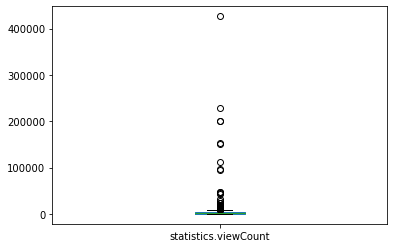

In [138]:
x = df1['statistics.viewCount']
x = x.astype('int')
x.plot.box()

In [141]:
x.max()

426675

In [155]:
df1[df1['statistics.viewCount']==str(x.max())]

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt
17,"I didn't eat food for 4 days, here's what happ...","[what is like to do an extended fast?, intermi...",PT45M41S,426675,4907,490,934,2019-09-15T12:06:12Z
